In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima
from pylab import rcParams
from statsmodels.tsa.seasonal import STL
plt.style.use('fivethirtyeight')

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

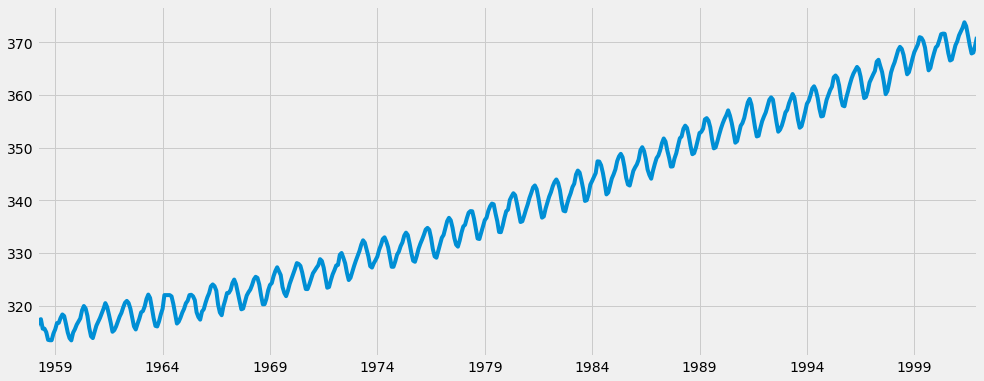

In [3]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))
plt.show()

In [4]:
y = y.fillna(y.bfill())

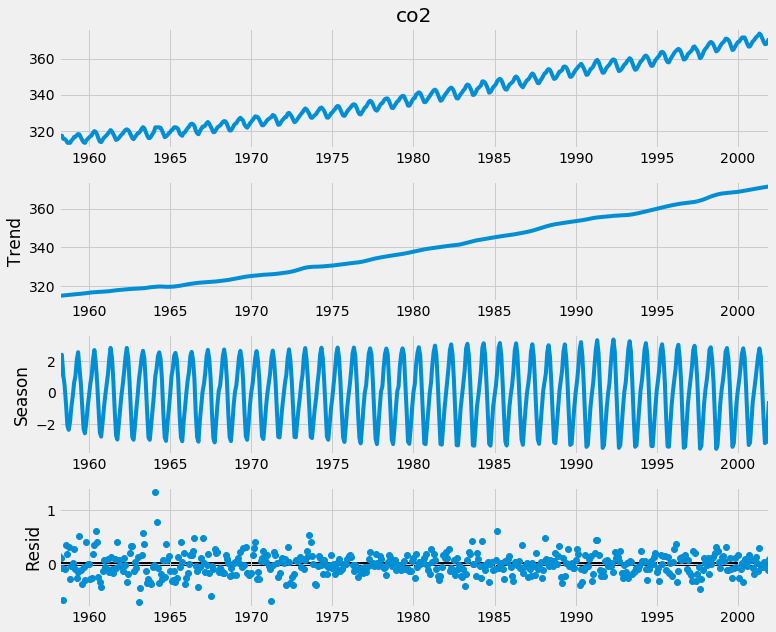

In [5]:
rcParams['figure.figsize'] = 11, 9
stl = STL(y).fit()
fig = stl.plot()
plt.show()

In [6]:
stl.seasonal

1958-03-01    1.008012
1958-04-01    2.066135
1958-05-01    2.418907
1958-06-01    1.115563
1958-07-01    0.473833
                ...   
2001-08-01   -1.627714
2001-09-01   -3.196119
2001-10-01   -3.131050
2001-11-01   -1.869247
2001-12-01   -0.528166
Freq: MS, Name: season, Length: 526, dtype: float64

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [8]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036737
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641156
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287855610497
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912934656
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755126321
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327718421
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067330986
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716776201
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1084.9453872064087
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4313909247412
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893630987
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988821106
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194085


In [9]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3180      0.092      3.444      0.001       0.137       0.499
ma.L1         -0.6255      0.076     -8.177      0.000      -0.775      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8766      0.026    -33.754      0.000      -0.927      -0.826
sigma2         0.0971      0.004     22.637      0.000       0.089       0.106


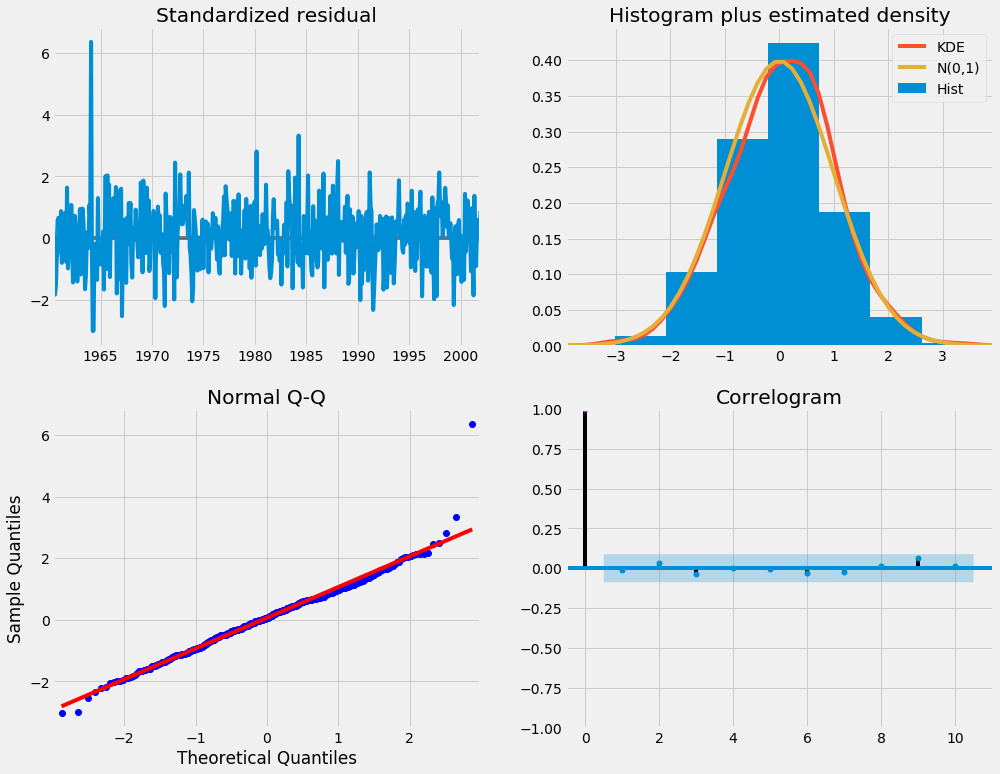

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [11]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

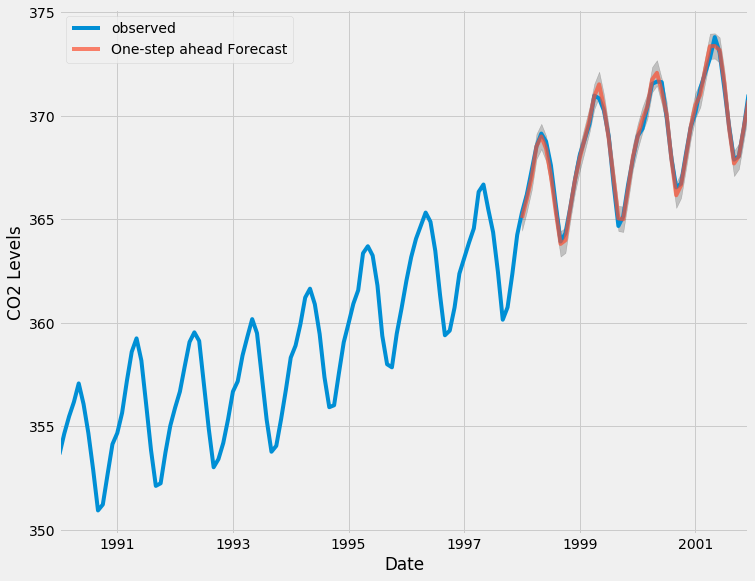

In [12]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

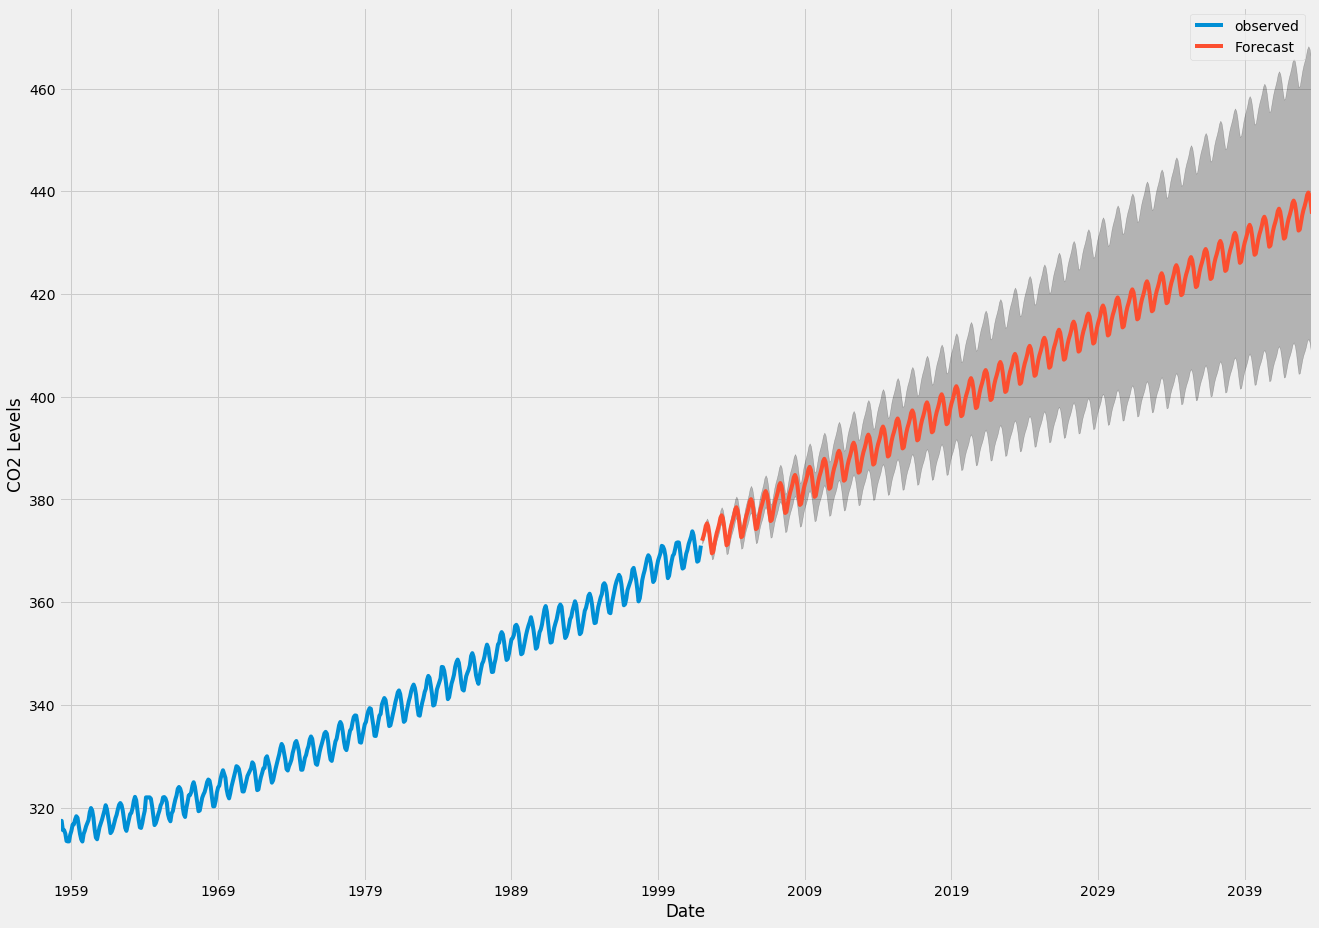

In [13]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()